In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/sines_4/orig_0_1_2_cnmp/1717597581/'

data_path = root_path + test_path + 'y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')

num_modes = 4
num_demos = Y.shape[0]
num_indiv = Y.shape[0]//num_modes
t_steps = Y.shape[1]

Y_means = np.zeros((num_modes,Y.shape[1]))
for i in range(num_modes):
    Y_means[i] = np.mean(Y[i*num_indiv:(i+1)*num_indiv], axis=0)

x: (200,), Y: (128, 200)


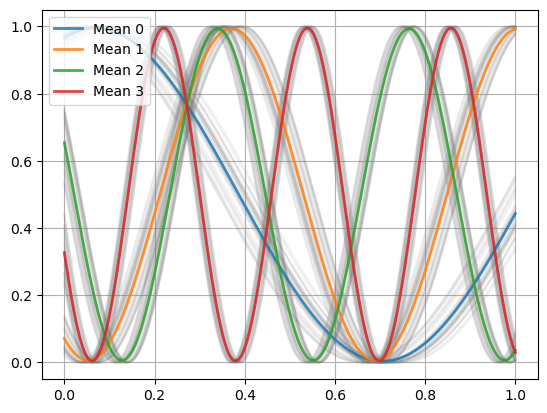

In [3]:
# plot Y and Y_means
plt.plot(x, Y.T, color='gray', alpha=0.1)
for i, traj in enumerate(Y_means):
    plt.plot(x, traj, label=f'Mean {i}', alpha=0.85, linewidth=2)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [4]:
# import numpy as np
# import os

# save_path = 'data/synthetic/sines_4'

# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# try:
#     os.makedirs(f'{save_path}_0')
#     os.makedirs(f'{save_path}_1')
#     os.makedirs(f'{save_path}_2')
#     os.makedirs(f'{save_path}_3')
# except:
#     pass

# num_demos = Y.shape[0]
# t_steps = Y.shape[1]
# num_classes = num_modes

# for i in range(num_demos):
#     traj = np.zeros((1, t_steps, 2))
#     traj[0, :, 0] = x.copy()
#     traj[0, :, 1] = Y[i, :].copy()
        
#     np.save(f'{save_path}_{i//num_indiv}/{i%num_indiv}.npy', traj)

In [5]:
def find_closest_traj_ind(traj):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    for i, y in enumerate(Y):
        dist = compute_rmse(y, traj)  # euclidean distance between two trajectories
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind


def compute_rmse(traj0, traj1, cut=0):
    # RMSE between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.sqrt(np.mean((t0[:-cut] - t1[:-cut]) ** 2))
    return np.sqrt(np.mean((t0 - t1) ** 2))


def compute_mae(traj0, traj1, cut=0):
    # MAE between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.mean(np.abs(t0[:-cut] - t1[:-cut]))
    return np.mean(np.abs(t0 - t1))


def compute_max_error(traj0, traj1, cut=0):
    # maximum error between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.max(np.abs(t0[:-cut] - t1[:-cut]))
    return np.max(np.abs(t0 - t1))

In [6]:
# d = DMP(n_dims=1, n_weights_per_dim=4, dt=1/(Y.shape[1]-1))  # -1 so that it uses Y.shape[1] points

# for i, traj in enumerate(Y):
#     d.imitate(x, traj.reshape(-1,1))

# p = ProMP(n_dims=1, n_weights_per_dim=4)
# p.imitate(np.tile(x, (Y.shape[0], 1)), Y)

# input_data = x.reshape(-1, 1)  # Phase variable as a column vector

# priors = 4  # Number of GMM components
# gmr_model = GMM(n_components=priors, random_state=1234)
# gmr_model.from_samples(Y)

In [7]:
model_folder = 'saved_models/'
models_path = f'{root_path}{test_path}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 10, 10
t_steps = Y.shape[1]
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [104,104], decoder_hidden_dims=[104,104], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)
val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)

In [ ]:
def random_points_on_demo(n):
    rand_x = np.zeros((n, 1))
    rand_y = np.zeros((n, 1))
    for i in range(n):
        rand_ind = np.random.randint(0, t_steps)
        rand_x[i] = x[rand_ind]
        rand_y[i] = Y[np.random.randint(0, num_demos)][rand_ind]
    
    return rand_x, rand_y

def intersection_points_on_demo(n):
    rand_points = np.zeros((n, 2))

    found = 0
    while found < n:
        rand_ind = np.random.randint(0, t_steps)
        for i in range(num_modes):
            for j in range(num_modes):
                if i==j:
                    continue
                elif np.abs(Y_means[i][rand_ind] - Y_means[j][rand_ind]) < 0.1:
                    rand_points[found, 0] = x[rand_ind]
                    rand_points[found, 1] = 0.5 * (Y_means[i][rand_ind] + Y_means[j][rand_ind])
                    found += 1

In [8]:
from tqdm import tqdm

num_demos = Y.shape[0]
num_tests = 100

# y0 = np.mean(Y[:, 0])
# y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y_min, y_max = np.min(Y[:, 0]), np.max(Y[:, 0])
y1s = Y_means[:, -1]

y0s = np.linspace(y_min, y_max, num_tests)

num_models = 10
# 0: DMP, 1: ProMP, 2: GMR, 3: CNMP, 4: StableMP, 5:CNEP, 6: CNEP-MoE, 7: CNEP-A0, 8: CNEP-A1, 9: CNEP-A2

rmse_errors = np.zeros((num_tests*num_modes, num_models))  # num_models models
mae_errors = np.zeros((num_tests*num_modes, num_models))
max_errors = np.zeros((num_tests*num_modes, num_models))

smp_trajs = np.load('4_sines_smp_5_types.npy')

for i1 in range(num_modes):
    for i0 in tqdm(range(num_tests)):
        d = DMP(n_dims=1, n_weights_per_dim=20, dt=(1/199))

        for traj in Y:
            d.imitate(x, traj.reshape(-1,1))

        p = ProMP(n_dims=1, n_weights_per_dim=20)
        p.imitate(np.tile(x, (num_demos, 1)), Y)

        input_data = x.reshape(-1, 1)  # Phase variable as a column vector

        priors = 20  # Number of GMM components
        gmr_model = GMM(n_components=priors, random_state=1234)
        gmr_model.from_samples(Y)

        y0 = y0s[i0]
        y1 = y1s[i1]

        # DMP
        d.configure(start_y=[y0], goal_y=[y1])
        t, trajectory = d.open_loop()

        # ProMP
        p = p.condition_position(y0, t=0).condition_position(y1, t=1)
        trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

        # GMR
        gmr_model_ = gmr_model.condition([0, -1], [y0, y1])
        trajectory_g = gmr_model_.sample(1)
        trajectory_g = np.insert(trajectory_g, 0, y0)
        trajectory_g = np.append(trajectory_g, y1)

        # CNMP and CNEP
        val_obs[0, :2, dx:] = torch.tensor([y0, y1]).unsqueeze(1)

        with torch.no_grad():
            trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
            pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
            dec_id = torch.argmax(gate.squeeze(1), dim=-1)
            trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

            confs = gate.view(4, 1, 1, 1)
            preds = pred_cnep[:, :, :, :dy]

            weighted_preds = preds * confs  # Element-wise multiplication, shape (num_gates, 1, 200, 1)
            trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

            pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
            dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
            trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

            pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
            dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
            trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

            pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
            dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
            trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]


        for j in range(num_models):
            if j == 0:
                traj = trajectory
            elif j == 1:
                traj = trajectory_p.squeeze(0)
            elif j == 2:
                traj = trajectory_g
            elif j == 3:
                traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
            elif j == 4:  # offline test
                traj = smp_trajs[i1*num_tests+i0]
            elif j == 5:
                traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
            elif j == 6:
                traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
            elif j == 7:
                traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
            elif j == 8:
                traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
            elif j == 9:
                traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

            closest_traj_ind = find_closest_traj_ind(traj)

            cut = 0
            if j == 4:
                cut = 2

            rmse_errors[i1*num_tests+i0, j] = compute_rmse(traj, Y[closest_traj_ind], cut)
            mae_errors[i1*num_tests+i0, j] = compute_mae(traj, Y[closest_traj_ind], cut)
            max_errors[i1*num_tests+i0, j] = compute_max_error(traj, Y[closest_traj_ind], cut)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [20:00<00:00, 12.01s/it]


In [9]:
# print mean errors and standard deviations
print('RMSE')
print(np.mean(rmse_errors, axis=0))
print(np.std(rmse_errors, axis=0))
print('MAE')
print(np.mean(mae_errors, axis=0))
print(np.std(mae_errors, axis=0))
print('Max error')
print(np.mean(max_errors, axis=0))
print(np.std(max_errors, axis=0))

RMSE
[0.4450987  0.20103498 0.37368826 0.20731826 0.14243961 0.24889287
 0.24846093 0.19734675 0.17198964 0.23878796]
[0.31261216 0.05289235 0.22455596 0.0821894  0.13263796 0.35703113
 0.35641556 0.08187298 0.0945668  0.10614434]
MAE
[0.40476225 0.16808503 0.29013263 0.16917723 0.1060665  0.21443668
 0.21403266 0.1616576  0.14146706 0.20128718]
[0.33276661 0.04580246 0.16997547 0.06965254 0.10698413 0.33157918
 0.33117179 0.06665192 0.07875952 0.08893755]
Max error
[0.6597612  0.42129867 0.69093068 0.44091745 0.36951457 0.45140499
 0.45199612 0.45459194 0.38117764 0.48199605]
[0.29113119 0.12437362 0.43207227 0.18910123 0.22338846 0.49823673
 0.49643394 0.23704986 0.21107668 0.22859834]


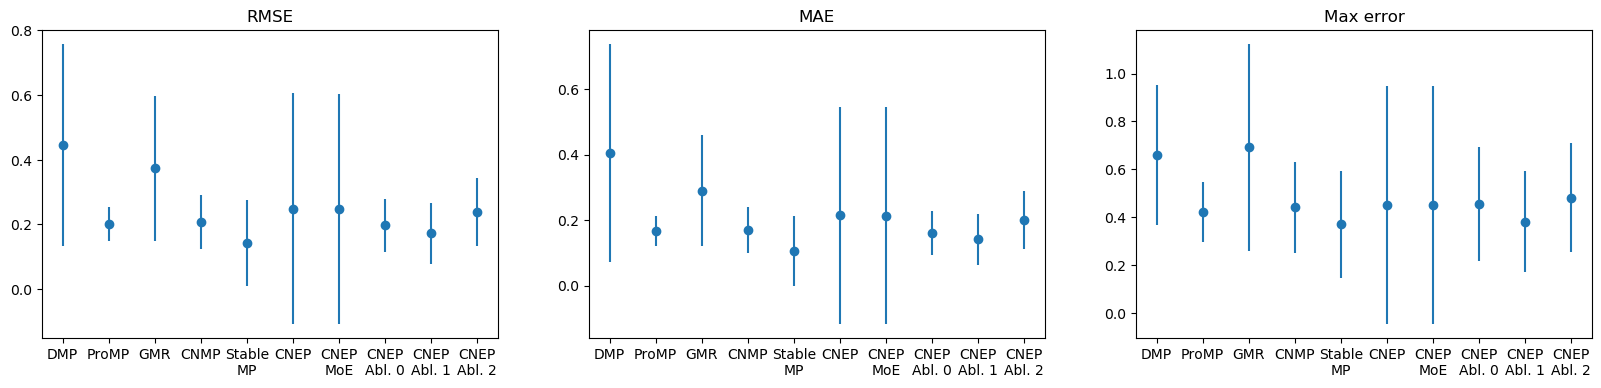

In [10]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
ax[0].set_title('RMSE')
ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()
# plt.savefig('table4_0.png')


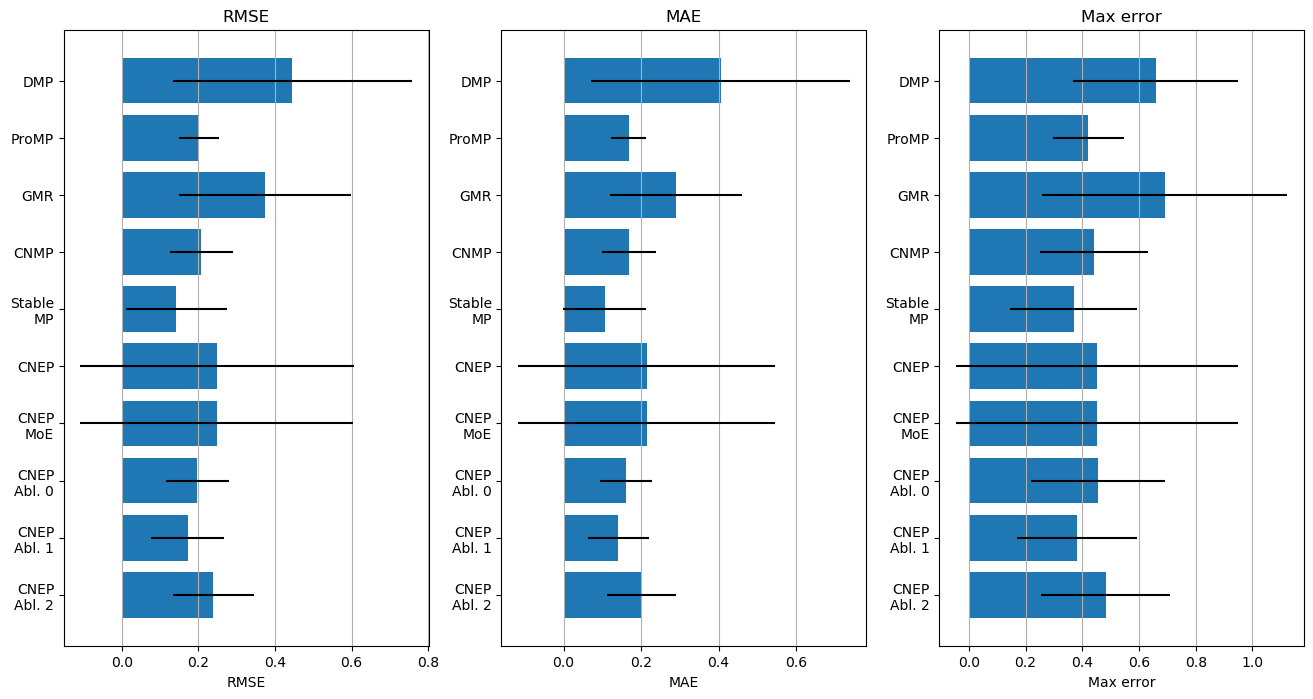

In [11]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(rmse_errors, axis=0), xerr=np.std(rmse_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('RMSE')
ax[0].set_title('RMSE')
ax[1].barh(y_pos, np.mean(mae_errors, axis=0), xerr=np.std(mae_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(max_errors, axis=0), xerr=np.std(max_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()
# plt.savefig('table4_1.png')

In [12]:
print(y0s)

[0.01903924 0.02891643 0.03879361 0.04867079 0.05854798 0.06842516
 0.07830234 0.08817952 0.09805671 0.10793389 0.11781107 0.12768826
 0.13756544 0.14744262 0.1573198  0.16719699 0.17707417 0.18695135
 0.19682854 0.20670572 0.2165829  0.22646008 0.23633727 0.24621445
 0.25609163 0.26596882 0.275846   0.28572318 0.29560037 0.30547755
 0.31535473 0.32523191 0.3351091  0.34498628 0.35486346 0.36474065
 0.37461783 0.38449501 0.39437219 0.40424938 0.41412656 0.42400374
 0.43388093 0.44375811 0.45363529 0.46351247 0.47338966 0.48326684
 0.49314402 0.50302121 0.51289839 0.52277557 0.53265276 0.54252994
 0.55240712 0.5622843  0.57216149 0.58203867 0.59191585 0.60179304
 0.61167022 0.6215474  0.63142458 0.64130177 0.65117895 0.66105613
 0.67093332 0.6808105  0.69068768 0.70056486 0.71044205 0.72031923
 0.73019641 0.7400736  0.74995078 0.75982796 0.76970515 0.77958233
 0.78945951 0.79933669 0.80921388 0.81909106 0.82896824 0.83884543
 0.84872261 0.85859979 0.86847697 0.87835416 0.88823134 0.8981